In [ ]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import numpy as np
import time
from math import sin, cos, radians

In [ ]:
!wget https://raw.githubusercontent.com/Joseph-Rance/Com-Soc-robotic-arm/master/ml%20team/classified%20images/3/input%20background.jpg

--2020-09-07 14:24:50--  https://raw.githubusercontent.com/Joseph-Rance/Com-Soc-robotic-arm/master/ml%20team/classified%20images/3/input%20background.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9661 (9.4K) [image/jpeg]
Saving to: ‘input background.jpg’

input background.jp 100%[===================>]   9.43K  --.-KB/s    in 0s      

2020-09-07 14:24:51 (71.8 MB/s) - ‘input background.jpg’ saved [9661/9661]



In [ ]:
!wget https://raw.githubusercontent.com/Joseph-Rance/Com-Soc-robotic-arm/master/ml%20team/classified%20images/3/input%20image.jpg

--2020-09-07 14:24:51--  https://raw.githubusercontent.com/Joseph-Rance/Com-Soc-robotic-arm/master/ml%20team/classified%20images/3/input%20image.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21020 (21K) [image/jpeg]
Saving to: ‘input image.jpg’

input image.jpg     100%[===================>]  20.53K  --.-KB/s    in 0.004s  

2020-09-07 14:24:51 (4.84 MB/s) - ‘input image.jpg’ saved [21020/21020]



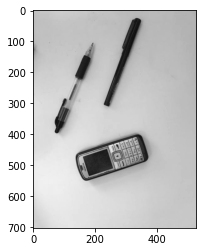

In [ ]:
img1 = imread('input background.jpg')
if img1.ndim == 3:
    img1 = img1.mean(axis=2)

img2 = imread('input image.jpg')
if img2.ndim == 3:
    img2 = img2.mean(axis=2)
    
plt.imshow(img2, cmap='gray')

In [ ]:
def median_filter(input_image, s):
    new_image = np.zeros((input_image.shape[0], input_image.shape[1]))
    for r in range(0, input_image.shape[1]):
        for c in range(0, input_image.shape[0]):
            values = []
            for ri in range(max(0, r - s), min(input_image.shape[1], r + s)):
                for ci in range(max(0, c - s), min(input_image.shape[0], c + s)):
                    values.append(input_image[ci, ri])
            values = sorted(values)
            new_image[c, r] = values[int(len(values) / 2)]

    return new_image

In [ ]:
threshold_function = lambda image, threshold : np.asarray([[pixel>=threshold for pixel in row] for row in image])

In [ ]:
downsize = lambda img, sf : np.array([[img[j, i] for i in range(0, len(img[0]), sf)] for j in range(0, len(img), sf)])

In [ ]:
def dilate(image, radius):
  new_image = np.zeros(image.shape)
  image = np.pad(image, radius)
  for y in range(2, image.shape[0]-2):
    for x in range(2, image.shape[1]-2):
      coords = [[(y+j, x+i) for j in range(-radius, radius+1)] for i in range(-radius, radius+1)]
      total = np.asarray([[image[j] for j in i] for i in coords]).any()
      new_image[y-radius*2, x-radius*2] = total != 0
  return new_image

In [ ]:
def DBSCAN(image, radius, core_threshold):

  points = []

  for y in range(len(image)):
    for x in range(len(image[y])):
      if image[y,x] == 1:
        points.append([(y,x), 0])

  groups = [0]  # group 0 -> noise (default)

  for point in points:

    surrounding_points = []
    for other_point in points:
      if ((point[0][0] - other_point[0][0])**2 + (point[0][1] - other_point[0][1])**2)**0.5 <= radius and point != other_point:
        surrounding_points.append(other_point)
    
    if len(surrounding_points) >= core_threshold:

      if sum([p[1] for p in surrounding_points]) == 0:  # no groups
        new_group = groups[-1] + 1
        groups.append(new_group)

        for p in surrounding_points:
          p[1] = new_group  # changes main points list as list is reference

      elif sum([p[1]>0 for p in surrounding_points]) == 1:  # one group
        
        group = -1  # group should never stay -1
        for p in surrounding_points:
            group = p[1] if p[1] > 0 else group

        for p in surrounding_points:
          p[1] = group

      else:  # >1 group

        surrounding_groups = []
        for p in surrounding_points:
            if p[1] not in surrounding_groups and p[1] != 0:
              surrounding_groups.append(p[1])

        for p in surrounding_points:
          p[1] = surrounding_groups[0]

        for p in points:
          if p[1] in surrounding_groups:
            p[1] = surrounding_groups[0]

  del groups[0]  # noise group
  centres = [[0, 0] for i in groups]
  totals = [0 for i in groups]

  for point in points:
    if point[1] != 0:
      centres[groups.index(point[1])][0] += point[0][0]
      centres[groups.index(point[1])][1] += point[0][1]
      totals[groups.index(point[1])] += 1

  for i in range(len(groups)):
    if totals[i] > 0:
      centres[i][0] /= totals[i]
      centres[i][1] /= totals[i]

  loss = 0
  for point in points:
    distances = np.array([((point[0][0] - centre[0])**2 + (point[0][1] - centre[1])**2)**0.5 for centre in centres])
    loss += min(distances)

  del_list = []
  for i in range(len(centres)):
    if centres[i] == [0, 0]:
      del_list.append(i)
  for i in sorted(del_list)[::-1]: del centres[i]

  return points, centres, loss

In [ ]:
def get_rotations(image, centres, centre_idx=0, debug=False):

  def check_line_length(centre, angle, image):  # angle is from line to right

    def dist(p1, p2):
      return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

    hyp = 0
    still_on_obj_pos = still_on_obj_neg = True
    coords = [(), ()]

    while still_on_obj_pos or still_on_obj_neg:
      hyp += 2
      dy = hyp * sin(angle)  # keep angle in radians
      dx = hyp * cos(angle)
      try:
        if image[round(centre[0]+dy), round(centre[1]+dx)] == 0 and still_on_obj_pos:
          still_on_obj_pos = False
          coords[0] = (round(centre[0]+dy), round(centre[1]+dx))
      except IndexError:
        if still_on_obj_pos:
          still_on_obj_pos = False
          coords[0] = (round(centre[0]+dy), round(centre[1]+dx))

      try:
        if image[round(centre[0]-dy), round(centre[1]-dx)] == 0 and still_on_obj_neg:
          still_on_obj_neg = False
          coords[1] = (round(centre[0]-dy), round(centre[1]-dx))
      except IndexError:
        if still_on_obj_neg:
          still_on_obj_neg = False
          coords[1] = (round(centre[0]-dy), round(centre[1]-dx))

    return dist(*coords)

  if debug:
    return [check_line_length(centres[centre_idx], radians(angle), image) for angle in range(0, 180, 2)]
  return np.argmin(np.asarray([check_line_length(centres[centre_idx], radians(angle), image) for angle in range(0, 180, 2)]))  # only one returned because we only do one rotation per time

In [ ]:
scaling = 8
filter_radius = 2
threshold = 60
dbscan_radius = 5
dbscan_core_threshold = 3

In [ ]:
start_time = time.clock()
img = np.absolute(img1 - img2)
img = downsize(img, scaling)
img = median_filter(img, filter_radius)
img = threshold_function(img, threshold)
img = dilate(img, 2)
centres = DBSCAN(img, dbscan_radius, dbscan_core_threshold)[1]
print(centres)
print(f"Time elapsed: {round(time.clock() - start_time, 2)}s")

[[18.78723404255319, 34.56534954407295], [21.99173553719008, 18.60330578512397], [41.91935483870968, 10.201612903225806], [57.97849462365591, 30.10322580645161]]
Time elapsed: 1.11s


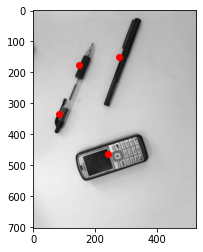

In [ ]:
plt.imshow(img2, cmap="gray")
plt.scatter([centre[1]*scaling for centre in centres], [centre[0]*scaling for centre in centres], c="r")
plt.show()

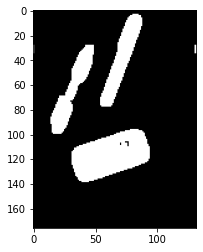

In [ ]:
start_time = time.clock()
img = np.absolute(img1 - img2)
img = downsize(img, 4)
img = median_filter(img, 2)
img = threshold_function(img, 40)
img = dilate(img, 2)
plt.imshow(img, cmap="gray")
plt.show()

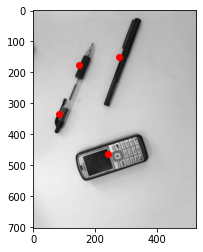

In [ ]:
start_time = time.clock()
img = np.absolute(img1 - img2)
img = downsize(img, scaling)
img = median_filter(img, filter_radius)
img = threshold_function(img, threshold)
img = dilate(img, 2)
points = DBSCAN(img, dbscan_radius, dbscan_core_threshold)[0]

temp_image = np.zeros((img.shape[0], img.shape[1]))
for point in points:
  temp_image[point[0][0], point[0][1]] = point[1] + 1
imgplot = plt.imshow(img2, cmap="gray")
plt.scatter([centre[1]*scaling for centre in centres], [centre[0]*scaling for centre in centres], c="r")
#imgplot = plt.imshow(temp_image)
#plt.scatter([centre[1] for centre in centres], [centre[0] for centre in centres], c="r")

In [ ]:
def DBSCAN_outline(image, radius, core_threshold):

  def dist(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

  points = []

  for y in range(len(image)):
    for x in range(len(image[y])):
      if image[y,x] == 1:
        points.append((y,x))

  for point in points:

    no_surrounding_points = 0

    for other_point in points:
      if dist(point, other_point) <= radius:
        no_surrounding_points += 1
    
    if no_surrounding_points >= core_threshold:
      image[point] = 2

  return image

In [ ]:
scaling = 8
filter_radius = 2
threshold = 40
dbscan_radius = 5
dbscan_core_threshold = 3
dilate_size = 2
centre_idx = 2

In [ ]:
def move_centres(image, centres):

  new_centres = [(1e5, 1e5) for i in centres]

  def dist(p1, p2):
    return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

  points = []

  for y in range(len(image)):
    for x in range(len(image[y])):
      if image[y,x] == 1:
        points.append((y,x))

  for point in points:
    for i, centre in enumerate(centres):
      distance = dist(point, centre)
      if distance < new_centres[i][1]:
        new_centres[i] = (point, distance)

  return [i[0] for i in new_centres]

In [ ]:
def add_line(centre, angle, image):

    def dist(p1, p2):
      return ((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)**0.5

    hyp = 0
    still_on_obj_pos = still_on_obj_neg = True
    coords = [(), ()]

    while still_on_obj_pos or still_on_obj_neg:
      hyp += 2
      dy = hyp * sin(angle)  # keep angle in radians
      dx = hyp * cos(angle)
      try:
        if image[round(centre[0]+dy), round(centre[1]+dx)] == 0 and still_on_obj_pos:
          still_on_obj_pos = False
      except IndexError:
        if still_on_obj_pos:
          still_on_obj_pos = False

      try:
        if image[round(centre[0]-dy), round(centre[1]-dx)] == 0 and still_on_obj_neg:
          still_on_obj_neg = False
      except IndexError:
        if still_on_obj_neg:
          still_on_obj_neg = False
        
      image[round(centre[0]+dy), round(centre[1]+dx)], image[round(centre[0]-dy), round(centre[1]-dx)] = 2, 2

    return image

In [ ]:
start_time = time.clock()
img = np.absolute(img1 - img2)
img = downsize(img, scaling)
img = median_filter(img, filter_radius)
img = threshold_function(img, threshold)
img = dilate(img, dilate_size)
centres = DBSCAN(img, dbscan_radius, dbscan_core_threshold)[1]
centres = move_centres(img, centres)
angle = get_rotations(img, centres, centre_idx=centre_idx)

print(f"Time elapsed: {round(time.clock() - start_time, 2)}s")
print(angle)
img = add_line(centres[centre_idx], radians(angle), img)
plt.imshow(img)
plt.scatter(centres[centre_idx][1], centres[centre_idx][0], c="r")
plt.show()

TypeError: ignored

In [ ]:
print(angle)

[12.0, 12.0, 12.041594578792296, 12.041594578792296, 12.165525060596439, 12.165525060596439, 10.44030650891055, 10.44030650891055, 11.40175425099138, 9.848857801796104, 9.848857801796104, 9.848857801796104, 9.848857801796104, 9.848857801796104, 10.295630140987, 10.295630140987, 10.295630140987, 10.816653826391969, 10.816653826391969, 11.40175425099138, 12.041594578792296, 12.041594578792296, 12.041594578792296, 12.727922061357855, 12.041594578792296, 12.041594578792296, 11.40175425099138, 12.206555615733702, 12.206555615733702, 12.206555615733702, 11.661903789690601, 14.317821063276353, 14.317821063276353, 14.317821063276353, 14.317821063276353, 15.811388300841896, 15.811388300841896, 15.811388300841896, 17.72004514666935, 22.561028345356956, 22.20360331117452, 22.20360331117452, 22.20360331117452, 26.019223662515376, 26.019223662515376, 28.0, 30.01666203960727, 32.0624390837628, 38.2099463490856, 40.311288741492746, 41.593268686170845, 41.97618372363071, 42.20189569201838, 43.68065933

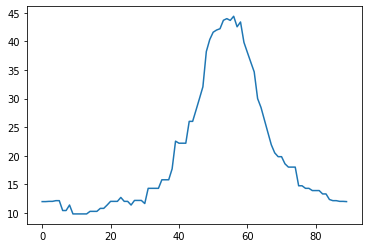

In [ ]:
plt.plot(angle)

In [ ]:
# find optimised params
# contstrin centres